In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import json
import sys
import numpy as np
from scipy.stats import kurtosis, norm
from scipy.special import logsumexp
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm, trange
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp

sys.path.append('../scripts/python')
from parameter_estimation import BivariateBeta
from experiments import starting_experiment, starting_experiment_2

plt.style.use('science')

from autograd import grad
import autograd.numpy as np

## Second diagnostic

Presenting the use of method delta:

In [4]:
def h(x):   
    aux = x[2] * np.exp(0.5*(np.log(x[0]) + np.log1p(-x[0]) + np.log(x[1]) + np.log1p(-x[1])))
    v = np.array([aux + x[0]*x[1], aux + x[0]*(1-x[1]), aux + x[1]*(1-x[0]), aux + (1-x[0])*(1-x[1])])
    return np.prod(v)

grad_h = grad(h)

def matrix(x,y,D):
    Lambda = np.zeros((3,3))
    Lambda[:-1,:-1] = D*np.cov(x,y)
    Lambda[0,2] = Lambda[2,0] = np.sqrt(D)*np.cov(x, (x-x.mean())*(y-y.mean()))[0,1]
    Lambda[1,2] = Lambda[2,1] = np.sqrt(D)*np.cov(y, (x-x.mean())*(y-y.mean()))[0,1]
    Lambda[2,2] = np.var((x-x.mean())*(y-y.mean()))
    return Lambda

When $n=50$, it does not converge. 

In [7]:
true_alpha = np.array([2,1,1,1])
n = 50

m1, m2, v1, v2, rho = BivariateBeta(true_alpha).moments()
moments_true = np.array([m1,m2,rho])
derivative = grad_h(moments_true)
mean = h(moments_true)
v = []
for i in range(10000):
    U = np.random.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    moments_hat = np.array([X.mean(), Y.mean(), np.corrcoef(X,Y)[0,1]])
    #D = v1*v2
    #Lambda = matrix(X,Y,D)
    v.append(np.sqrt(n) * (h(moments_hat) - mean))#/np.sqrt(derivative @ Lambda @ derivative))

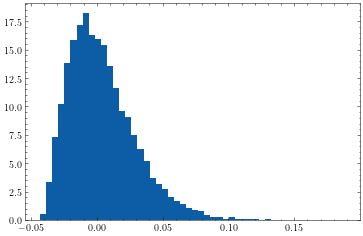

In [8]:
plt.hist(v, bins=50, density=True)
#t = np.linspace(-4,4,2000)
#plt.plot(t, norm(0, 1).pdf(t), color='black')
plt.show()

With $n=1000$

In [18]:
true_alpha = np.array([2,1,1,1])
n = 500

m1, m2, v1, v2, rho = BivariateBeta(true_alpha).moments()
moments_true = np.array([m1,m2,rho])
derivative = grad_h(moments_true)
mean = h(moments_true)
v = []
for i in range(10000):
    U = np.random.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    moments_hat = np.array([X.mean(), Y.mean(), np.corrcoef(X,Y)[0,1]])
    #D = v1*v2
    #Lambda = matrix(X,Y,D)
    v.append(np.sqrt(n) * (h(moments_hat) - mean))#/np.sqrt(derivative @ Lambda @ derivative))

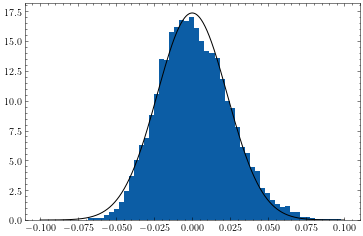

In [19]:
plt.hist(v, bins=50, density=True)
t = np.linspace(-0.1,0.1,2000)
plt.plot(t, norm(0, 0.023).pdf(t), color='black')
plt.show()

## Looking at the minimum statistic

Here we look for the minimum statistic for small values of $\alpha$. 
We can observe that it can get very small. 

In [36]:
rng = np.random.default_rng(671289)
true_alpha = np.array([1e-3,1e-1,2.5,1000.0])
n = 50

P_quantile = []

for i in trange(10000):
    true_alpha = np.random.uniform(0, 0.5, size=4)
    U = rng.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    P_values = []
    for i in range(500):
        indeces = np.random.choice(range(n), size=n)
        Xb = X[indeces]
        Yb = Y[indeces]
        m1 = np.mean(Xb)
        m2 = np.mean(Yb)
        rho = np.corrcoef(Xb, Yb)[0,1]
        D = rho * np.exp(0.5*(np.log(m1) + np.log1p(-m1) + np.log(m2) + np.log1p(-m2)))
        P = min(D + m1*m2, -D + m1*(1-m2), -D + m2*(1-m1), D + (1-m1)*(1-m2))
        P_values.append(P)
    P_quantile.append(np.quantile(P,0.05))

100%|█████████████████████████████████████| 10000/10000 [15:09<00:00, 11.00it/s]


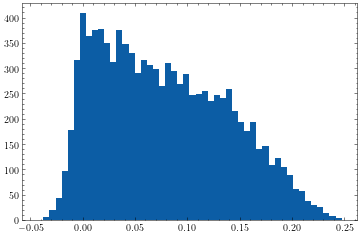

In [37]:
plt.hist(P_quantile, bins=50)
plt.show()

## That's not good because...

In [31]:
rng = np.random.default_rng(671289)
n = 50

Z = rng.multivariate_normal(mean=[1,1], cov=[[1,-0.6],[-0.6,1]], size=n)
X = 1/(1+np.exp(-Z[:,0]))
Y = 1/(1+np.exp(-Z[:,1]))

P_values = []

for i in range(500):
    indeces = np.random.choice(range(n), size=n)
    Xb = X[indeces]
    Yb = Y[indeces]
    m1 = np.mean(Xb)
    m2 = np.mean(Yb)
    rho = np.corrcoef(Xb, Yb)[0,1]
    D = rho * np.exp(0.5*(np.log(m1) + np.log1p(-m1) + np.log(m2) + np.log1p(-m2)))
    P = min(D + m1*m2, -D + m1*(1-m2), -D + m2*(1-m1), D + (1-m1)*(1-m2))
    P_values.append(P)

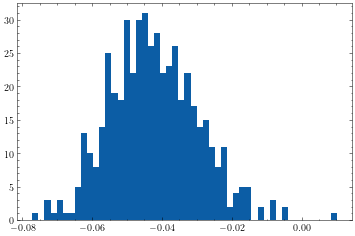

In [32]:
plt.hist(P_values, bins=50)
plt.show()

## What happens if $\alpha > 1$?

In [23]:
n = 50

P_values = []

for i in range(10000):
    alpha = np.random.uniform(1, 10, size=4)
    U = np.random.dirichlet(alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    m1 = X.mean()
    m2 = Y.mean()
    rho = np.corrcoef(X,Y)[0,1]
    D = rho * np.sqrt(m1*(1-m1)*m2*(1-m2))
    P = min([D + m1*m2, -D + m1*(1-m2), -D + m2*(1-m1), D + (1-m1)*(1-m2)])
    P_values.append(P)

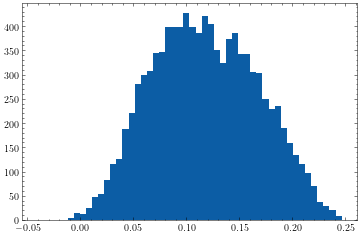

In [26]:
plt.hist(P_values, bins=50)
plt.show()

## Sensibility of the first diagnostic method

In [10]:
seed = np.random.randint(3219121)
rng = np.random.default_rng(seed)

S1_values = []
S2_values = []

for i in range(2000):

    X = rng.beta(2, 3, size=50)
    Y = rng.beta(1, 3, size=50)

    S1, _ = BivariateBeta().marginal_diagnostic(X,Y, which_g='divisor')
    S2, _ = BivariateBeta().marginal_diagnostic(X,Y, which_g='quadratic')

    S1_values.append(S1)
    S2_values.append(S2)

In [11]:
t = np.linspace(-4,4,1000)

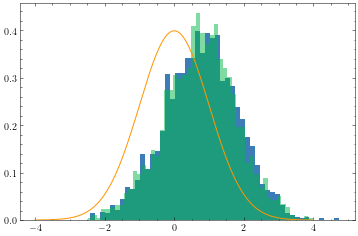

In [12]:
plt.hist(S1_values, bins=50, density=True, alpha=0.8)
plt.hist(S2_values, bins=50, density=True, alpha=0.5)
plt.plot(t, norm.pdf(t))
plt.show()

## Q-Q plot

I first will verify if Assingment problem is equivalent to sorting in the unidimensional setting.

In [13]:
n = 100
x = np.random.multivariate_normal(mean=np.zeros(1), cov=np.eye(1), size=n)
y = np.random.multivariate_normal(mean=np.zeros(1), cov=np.eye(1), size=n)

In [14]:
C = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        C[i,j] = (x[i] - y[j])**2
        
index1_assign, index2_assign = linear_sum_assignment(cost_matrix=C)
index1_sort, index2_sort = np.argsort(x, axis=0), np.argsort(y, axis=0)

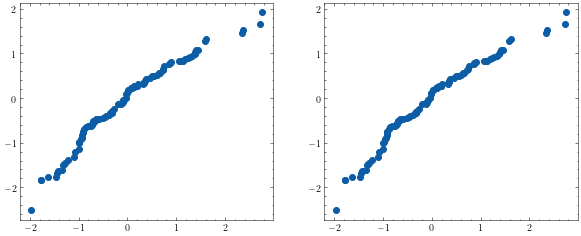

In [15]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(x[index1_sort], y[index2_sort])
ax[1].scatter(x[index1_assign], y[index2_assign])
plt.show()

In [16]:
n = 100
x = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=n)
y = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=n)

In [17]:
C = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        C[i,j] = np.linalg.norm(x[i] - y[j], ord=2)
        
index1, index2 = linear_sum_assignment(cost_matrix=C)

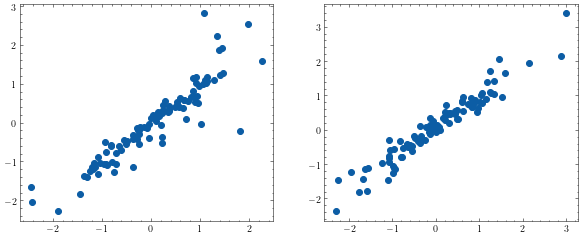

In [18]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(x[index1, 0], y[index2, 0])
ax[1].scatter(x[index1, 1], y[index2, 1])
plt.show()

The above graphic is called **fuzzy Q-Q plot**

## Well-specified case

In [30]:
rng = np.random.default_rng(61289)

true_alpha = np.array([2,7,3,1])
n = 100

U = rng.dirichlet(true_alpha, size=n)
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]
XY = np.column_stack([X,Y])

alpha_hat = BivariateBeta().method_moments_estimator_4(X,Y,alpha0=(1,1,1,1))
U = rng.dirichlet(alpha_hat, size=n)
X_hat = U[:,0] + U[:,1]
Y_hat = U[:,0] + U[:,2]
XY_hat = np.column_stack([X_hat, Y_hat])

C = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        C[i,j] = np.linalg.norm(XY[i] - XY_hat[j], ord=2)
        
index1, index2 = linear_sum_assignment(cost_matrix=C)

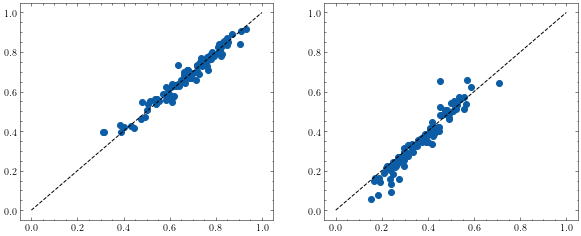

In [31]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(XY[index1, 0], XY_hat[index2, 0])
ax[1].scatter(XY[index1, 1], XY_hat[index2, 1])
ax[0].plot([0, 1], [0, 1], color='black', linestyle='--')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='--')
plt.show()

## Wrongly specified case

In [21]:
rng = np.random.default_rng(671289)
n = 100

X = rng.beta(1,3, size=n)
Y = rng.beta(4,5, size=n)
XY = np.column_stack([X,Y])

alpha_hat = BivariateBeta().method_moments_estimator_4(X,Y,alpha0=(1,1,1,1))
U = rng.dirichlet(alpha_hat, size=n)
X_hat = U[:,0] + U[:,1]
Y_hat = U[:,0] + U[:,2]
XY_hat = np.column_stack([X_hat, Y_hat])

C = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        C[i,j] = np.linalg.norm(XY[i] - XY_hat[j], ord=2)
        
index1, index2 = linear_sum_assignment(cost_matrix=C)

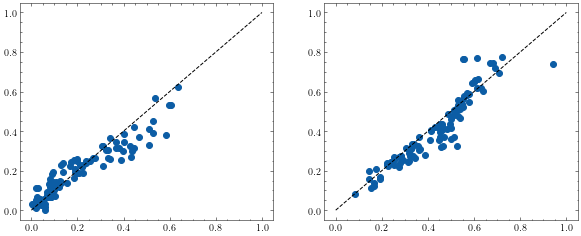

In [22]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(XY[index1, 0], XY_hat[index2, 0])
ax[1].scatter(XY[index1, 1], XY_hat[index2, 1])
ax[0].plot([0, 1], [0, 1], color='black', linestyle='--')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='--')
plt.show()

In [23]:
print(alpha_hat[0]+alpha_hat[1], alpha_hat[2]+alpha_hat[3])
print(alpha_hat[0]+alpha_hat[2], alpha_hat[1]+alpha_hat[3])

1.482793514762536 5.605288405676561
3.063375140237352 4.024706780201744


## Distance Q-Q Plot

In [24]:
n = 100
x = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=n)
y = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=n)

In [25]:
C = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        C[i,j] = np.linalg.norm(x[i] - y[j], ord=2)
index1, index2 = linear_sum_assignment(cost_matrix=C)

distances1 = np.sort(C[index1, index2])

distances2 = np.zeros(100)

for k in range(50):
    z = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=n)
    C = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            C[i,j] = np.linalg.norm(x[i] - z[j], ord=2)
    index1, index2 = linear_sum_assignment(cost_matrix=C)

    distances2 = (k * distances2 + np.sort(C[index1, index2]))/(k+1)

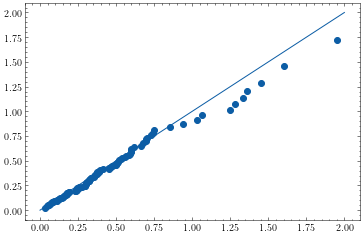

In [26]:
plt.scatter(distances1, distances2)
plt.plot([0,2], [0,2])
plt.show()